In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils import data
from eegnet_repl.dataset import build_dataset_from_preprocessed

# Load processed data

In [264]:
dataset = build_dataset_from_preprocessed(src='kaggle', subject=4)

2026-01-14 14:53:36,737 - dataset.py - build_dataset_from_preprocessed - INFO - Building dataset from preprocessed data in D:\!Studying\NeuroData\DS_n_advanced_python\HW\Final_project_DS\code\EEGNetReplication\data\processed
2026-01-14 14:53:36,739 - dataset.py - build_dataset_from_preprocessed - INFO - Found 1 preprocessed files for subject 4


Opening raw data file D:\!Studying\NeuroData\DS_n_advanced_python\HW\Final_project_DS\code\EEGNetReplication\data\processed\A04T-preprocessed.fif...
    Range : 0 ... 307667 =      0.000 ...  2403.648 secs
Ready.
Reading 0 ... 307667  =      0.000 ...  2403.648 secs...
Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('771'), np.str_('772')]


D:\!Studying\NeuroData\DS_n_advanced_python\HW\Final_project_DS\code\EEGNetReplication\src\eegnet_repl\dataset.py:163: RuntimeWarning: This filename (D:\!Studying\NeuroData\DS_n_advanced_python\HW\Final_project_DS\code\EEGNetReplication\data\processed\A04T-preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  pp = mne.io.read_raw_fif(file, preload=True)


Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 257 original time points ...
0 bad epochs dropped


In [265]:
dataset.X.shape

(144, 22, 257)

In [266]:
train_data, val_data = data.random_split(dataset=dataset,lengths=[0.8,0.2])

In [267]:
# 2.1. create data loader for the trainset (batch_size=64, shuffle=True)
train_loader = data.DataLoader(train_data, batch_size=32, shuffle=True)

# 2.2. create data loader for the valset (batch_size=64, shuffle=False)
val_loader = data.DataLoader(val_data, batch_size=32, shuffle=False)

In [268]:
dataiter = iter(train_loader)
batch_eeg, batch_labels = next(dataiter)

In [269]:
batch_eeg.shape

torch.Size([32, 22, 257])

In [270]:
batch_eeg[0,0,0]

tensor(-0.0397, dtype=torch.float64)

In [271]:
test = batch_eeg.float()
test[0,0,0].dtype

torch.float32

In [272]:
batch_labels

tensor([7, 7, 8, 8, 7, 8, 7, 8, 7, 8, 7, 7, 7, 8, 7, 8, 7, 7, 8, 8, 8, 8, 8, 8,
        8, 8, 7, 8, 7, 7, 8, 7])

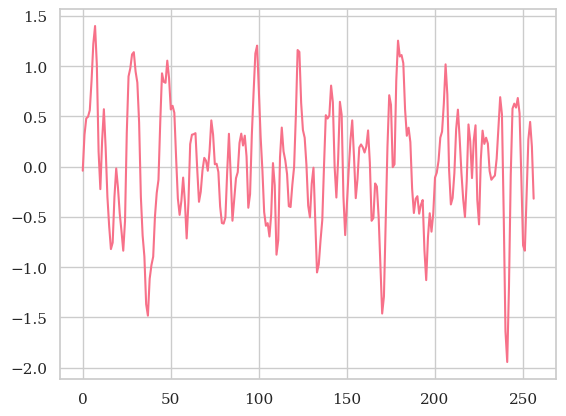

In [273]:
plt.plot(batch_eeg[0,0,:])

In [274]:
df = pd.DataFrame(batch_eeg[0].T)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       257 non-null    float64
 1   1       257 non-null    float64
 2   2       257 non-null    float64
 3   3       257 non-null    float64
 4   4       257 non-null    float64
 5   5       257 non-null    float64
 6   6       257 non-null    float64
 7   7       257 non-null    float64
 8   8       257 non-null    float64
 9   9       257 non-null    float64
 10  10      257 non-null    float64
 11  11      257 non-null    float64
 12  12      257 non-null    float64
 13  13      257 non-null    float64
 14  14      257 non-null    float64
 15  15      257 non-null    float64
 16  16      257 non-null    float64
 17  17      257 non-null    float64
 18  18      257 non-null    float64
 19  19      257 non-null    float64
 20  20      257 non-null    float64
 21  21      257 non-null    float64
dtypes:

2026-01-14 14:53:37,565 - category.py - update - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-14 14:53:37,572 - category.py - update - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


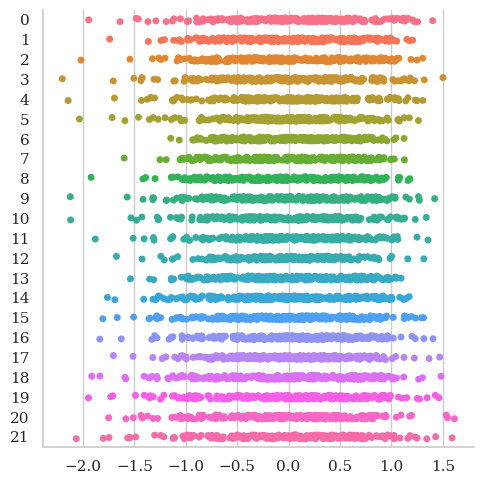

In [275]:
sns.catplot(data=df,kind='strip', orient='y')

# Architecture

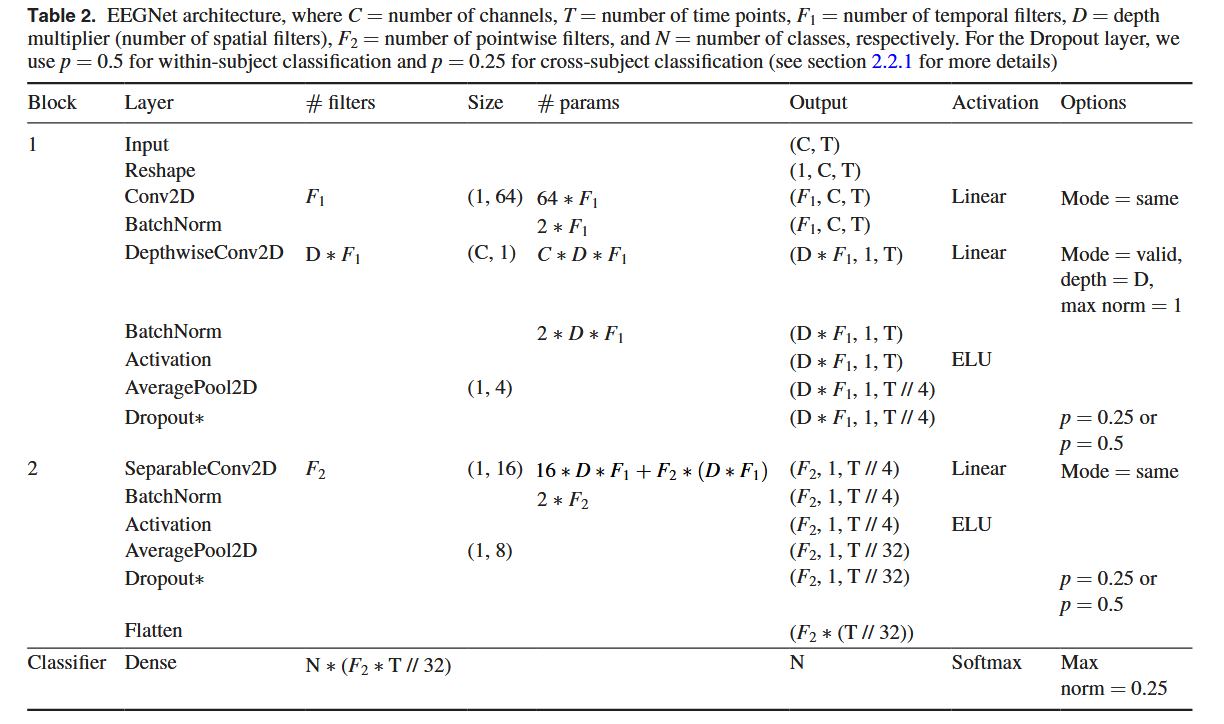

**EEGNet-8,2 parameters:**

F1 = 8 -> temporal filters

D = 2 -> spatial filters

F2 = F1*D -> pointwise convolutions, can be any number but authors choose this

In [276]:
# Define model
class reEEGNet(nn.Module):
    def __init__(self, C, T, F1=8, D=2, p=0.5):
        # C = number of channels, input.shape[1], C = 22 based on 02_preprocessing_pipeline
        # T = number of timepoints per batch, input.shape[2], T = 257 based on 02_preprocessing_pipeline
        # F1 = temporal filters
        # D = spatial filters
        # p = dropout probability: 0.5 for within-subject classification, 0.25 for cross-subject classification

        super().__init__()
        F2 = F1*D # pointwise convolutions, can be any number but authors choose this
        self.temporal = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=F1,
                kernel_size=(1,32),
                padding='same', # keeps initial dims per channel
                groups=1, # default
                bias=False # "We omit the use of bias units in all convolutional layers."
            ),
            # Linear activation = do nothing?
            nn.BatchNorm2d(num_features=F1)) # "We apply batch normalization along the feature map dimension"
        
        self.spatial = nn.Conv2d(
            in_channels=F1,
            out_channels=D*F1,
            kernel_size=(C,1), 
            padding='valid', # no padding -> collapses channel dimension
            groups=F1, # produces depthwise convolution
            bias=False # "We omit the use of bias units in all convolutional layers."
            )
        # "We also regularize each spatial filter by using a maximum norm constraint of 1 on its weights"
        max_norm_value = 1.0 
        self.spatial.weight.register_hook(lambda x: torch.clamp(x, min=-max_norm_value, max=max_norm_value))

        self.aggregation = nn.Sequential(
            nn.BatchNorm2d(num_features=D*F1), # "We apply batch normalization along the feature map dimension"
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1,4)), # default stride = kernel_size 
            nn.Dropout(p=p)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d( # depthwise part of separable convolution
            in_channels=D*F1,
            out_channels=D*F1,
            kernel_size=(1,16), 
            padding='same', # keeps initial dims per channel
            groups=D*F1, # produces depthwise convolution
            bias=False # "We omit the use of bias units in all convolutional layers."
            ),
            nn.Conv2d( # pointwise part of separable convolution
            in_channels=D*F1,
            out_channels=F2,
            kernel_size=(1,1), 
            padding='same', # keeps initial dims per channel, shouldn't matter in this case
            groups=1, # default
            bias=False # "We omit the use of bias units in all convolutional layers."
            ),
            # Linear activation = do nothing?
            nn.BatchNorm2d(num_features=F2), # "We apply batch normalization along the feature map dimension"
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1,8)), # default stride = kernel_size
            nn.Dropout(p=p),
            nn.Flatten()
        )

        self.classifier = nn.Linear(
                in_features=F2*(T//32),
                out_features=4, # number of classes
                bias=True # since it's not a convolutional layer..?
            )
        max_norm_value_1 = 0.25 
        self.classifier.weight.register_hook(lambda x: torch.clamp(x, min=-max_norm_value_1, max=max_norm_value_1))
        
        # nn.Softmax(dim=1) # dim = 0 is for batch number; comented out because of nn.CrossEntropyLoss() documentation:
        # "The input is expected to contain the unnormalized logits for each class (which do not need to be positive or sum to 1, in general)."



    def forward(self, x):
        x = torch.unsqueeze(x,dim=1) # inserts new dim at specified position, shape = (n_batches, C, T) -> shape = (n_batches, 1, C, T)
        filter_bank = self.temporal(x)
        spatial_pattern = self.spatial(filter_bank)
        block_1_out = self.aggregation(spatial_pattern)
        block_2_out = self.block_2(block_1_out)
        output = self.classifier(block_2_out)
        
        return output

In [277]:
model = reEEGNet(C=dataset.X.shape[1], T=dataset.X.shape[2])

In [278]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Model's state_dict:
temporal.0.weight 	 tensor([[[[ 0.1525,  0.0910,  0.1157,  0.0806, -0.1028,  0.0085,  0.0466,
            0.1615, -0.1642,  0.1413,  0.1640, -0.0139,  0.1732, -0.0994,
           -0.0039,  0.0597, -0.0641, -0.1041, -0.1725,  0.1479, -0.0169,
            0.0194,  0.0419,  0.1025,  0.1768, -0.0588,  0.0534, -0.0173,
           -0.0922,  0.1587,  0.0560, -0.1750]]],


        [[[ 0.1270,  0.1728,  0.0756,  0.0835,  0.1387,  0.0692,  0.0993,
            0.1391,  0.1538, -0.1228,  0.1212, -0.0967,  0.1523,  0.1500,
           -0.0249, -0.0380,  0.1055,  0.0723, -0.0642,  0.1047, -0.1061,
           -0.1528,  0.0580,  0.0638, -0.1678,  0.1160,  0.1615,  0.1362,
           -0.0758, -0.1604, -0.0170,  0.1127]]],


        [[[ 0.0201,  0.0773,  0.1683, -0.0033,  0.1252, -0.0800, -0.0914,
           -0.0851,  0.0117,  0.1032, -0.0838,  0.1370,  0.1550,  0.0306,
            0.0795, -0.0697, -0.0895, -0.0798, -0.1703, -0.0582,  0.0404,
           -0.0501, -0.1590,  0.0588, -0.0

In [279]:
print(model.parameters())

<generator object Module.parameters at 0x000002743D87B790>


# Training

"We run 500 training iterations (epochs) and perform validation stopping, saving the model weights which produced the lowest validation set loss."

In [280]:
loss_fn = nn.CrossEntropyLoss() # "minimizing the categorical cross-entropy loss function"

# "We fit the model using the Adam optimizer, using default parameters as described in [75]"
# they used tensorflow, for parameters shared with pytorch only eps is slightly different
optimizer = torch.optim.Adam(
    params = model.parameters(),
    eps=1e-07, # the only change from default eps=1e-8, shouldn't matter I think
    foreach=None, # default, "If memory is prohibitive, batch fewer parameters through the optimizer at a time or switch this flag to False"
    fused=None, # default, "To force running the for-loop implementation, pass False for either foreach or fused."
    )

In [281]:
def train(model, optimizer, loss_fn, train_loader, val_loader, nepochs=500):
    '''
    Train a pytorch model and evaluate it every epoch.
    Params:
    model - a pytorch model to train
    optimizer - an optimizer
    loss_fn - the criterion (loss function)
    nepochs - number of training epochs
    train_loader - dataloader for the trainset
    val_loader - dataloader for the valset

    Returns: 
    1. state_dict of the model with the lowest validation loss, 
    2. list of train losses,
    3. list of validation losses.
    '''
    
    train_losses, val_losses = [], []
    best_model = model.state_dict()

    for e in range(nepochs):
        running_loss = 0
        running_val_loss = 0
        for signals, labels in train_loader: # signals = (batch, C, T), labels = (batch, label)

            # Map the old values (7, 8, 9, 10) to new values (0, 1, 2, 3) -> need to change data processing later
            new_labels = torch.zeros_like(labels)
            new_labels[labels == 7] = 0
            new_labels[labels == 8] = 1
            new_labels[labels == 9] = 2
            new_labels[labels == 10] = 3
            
            signals = signals.float() # added to avoid dtype mismatch error
            # Training pass
            model.train() # set model in train mode
            preds = model(signals)
            loss = loss_fn(preds,new_labels)

            running_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    #else:
        val_loss = 0
        # Evalaute model on validation at the end of each epoch.
        with torch.no_grad():
            for signals, labels in val_loader: # signals = (batch, C, T), labels = (batch, label)

                # Map the old values (7, 8, 9, 10) to new values (0, 1, 2, 3) -> need to change data processing later
                new_labels = torch.zeros_like(labels)
                new_labels[labels == 7] = 0
                new_labels[labels == 8] = 1
                new_labels[labels == 9] = 2
                new_labels[labels == 10] = 3

                signals = signals.float() # added to avoid dtype mismatch error
                preds = model(signals)
                val_loss = loss_fn(preds,new_labels)

                running_val_loss += val_loss.item()

        # track train loss and validation loss
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(running_val_loss/len(val_loader))

        if running_val_loss == np.min(np.array(val_losses)):
            best_model = model.state_dict()

        if e%50==0:
            print("Epoch: {}/{}.. ".format(e+1, nepochs),
            "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
            "Validation Loss: {:.3f}.. ".format(running_val_loss/len(val_loader)))

    return best_model, train_losses, val_losses

In [282]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
best_model, train_losses, val_losses = train(model, optimizer, loss_fn, train_loader, val_loader, nepochs=50)

Using cpu device
Epoch: 1/50..  Training Loss: 1.454..  Validation Loss: 1.375.. 


In [171]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Model's state_dict:
temporal.0.weight 	 tensor([[[[ 0.1781, -0.0192,  0.1382, -0.0058,  0.0339, -0.1083, -0.0178,
           -0.1862,  0.0841, -0.1456, -0.0888, -0.0280,  0.0778,  0.0994,
            0.0178, -0.1171,  0.1445,  0.0599, -0.1744,  0.0877, -0.0108,
            0.1100,  0.1547, -0.1023,  0.0381, -0.0121, -0.1480,  0.0171,
            0.1680,  0.0131, -0.0302, -0.1574]]],


        [[[-0.0118, -0.1446, -0.0453,  0.0603, -0.1346, -0.1623, -0.0460,
           -0.0724,  0.1314,  0.0535,  0.1735,  0.1261,  0.0728,  0.1647,
           -0.1561,  0.0185,  0.0455, -0.1921,  0.0772,  0.0976,  0.0923,
            0.1254, -0.0055, -0.0508, -0.1019,  0.0592,  0.0624,  0.1093,
            0.1127, -0.1382,  0.0214,  0.0596]]],


        [[[-0.0898,  0.0498,  0.0610,  0.0722, -0.1544,  0.1734,  0.0980,
           -0.1226, -0.0699, -0.0075, -0.0504,  0.1403,  0.1348,  0.1334,
           -0.0494, -0.0494,  0.1203, -0.1619, -0.0939, -0.1667,  0.0300,
            0.1406, -0.0592, -0.1224, -0.1

Text(0, 0.5, 'Loss')

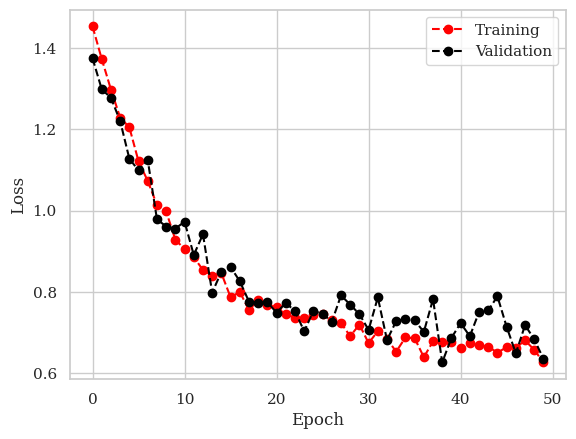

In [283]:
plt.plot(np.arange(len(train_losses)),train_losses,'ro--')
plt.plot(np.arange(len(val_losses)),val_losses,'ko--')
plt.legend(labels=['Training','Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [63]:
#torch.save(best_model, PATH)